# Week 1 challange

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
import nltk
from collections import Counter
import re
from datetime import datetime

In [41]:
# Download NLTK stopwords 
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to C:\Users\doff
[nltk_data]     n\AppData\Roaming\nltk_data...


True

## Descriptive Statistic

In [21]:
data = pd.read_csv(r"C:\Users\doff n\Desktop\doffneri\week1\src\raw_analyst_ratings.csv")

In [17]:
data.head()

,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [18]:
print(data.columns)
print(data.describe())

Index(['Unnamed: 0', 'headline', 'url', 'publisher', 'date', 'stock'], dtype='object')
         Unnamed: 0
count  1.407328e+06
mean   7.072454e+05
std    4.081009e+05
min    0.000000e+00
25%    3.538128e+05
50%    7.072395e+05
75%    1.060710e+06
max    1.413848e+06


### Identify which columns have NaN values

In [25]:
nan_columns = data.isnull().any()
print(nan_columns)

Unnamed: 0    False
headline      False
url           False
publisher     False
date          False
stock         False
dtype: bool


### Length of Each Textual Entry

In [26]:
data['headline_length'] = data['headline'].apply(len)
headline_stats = data['headline_length'].describe()

print("Headline Length Statistics:")
print(headline_stats)


Headline Length Statistics:
count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64


### Articles per publisher

In [27]:
publisher_counts = data['publisher'].value_counts()

print("\nTop 10 Publishers by Number of Articles:")
print(publisher_counts.head(10))



Top 10 Publishers by Number of Articles:
publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Name: count, dtype: int64


### Publication date trends

In [29]:
def convert_to_datetime(date_string):
    try:
        return datetime.strptime(date_string, "%Y-%m-%d %H:%M:%S")
    except ValueError:
        # Handle or log errors as needed
        return None


In [30]:
data['date'] = data['date'].apply(convert_to_datetime)


### Visualization


Publication Date Trends (first 10 dates):
date
2009-02-14    1
2009-04-27    2
2009-04-29    1
2009-05-22    1
2009-05-27    6
2009-05-29    2
2009-05-30    3
2009-06-01    5
2009-06-02    2
2009-06-05    6
Name: count, dtype: int64


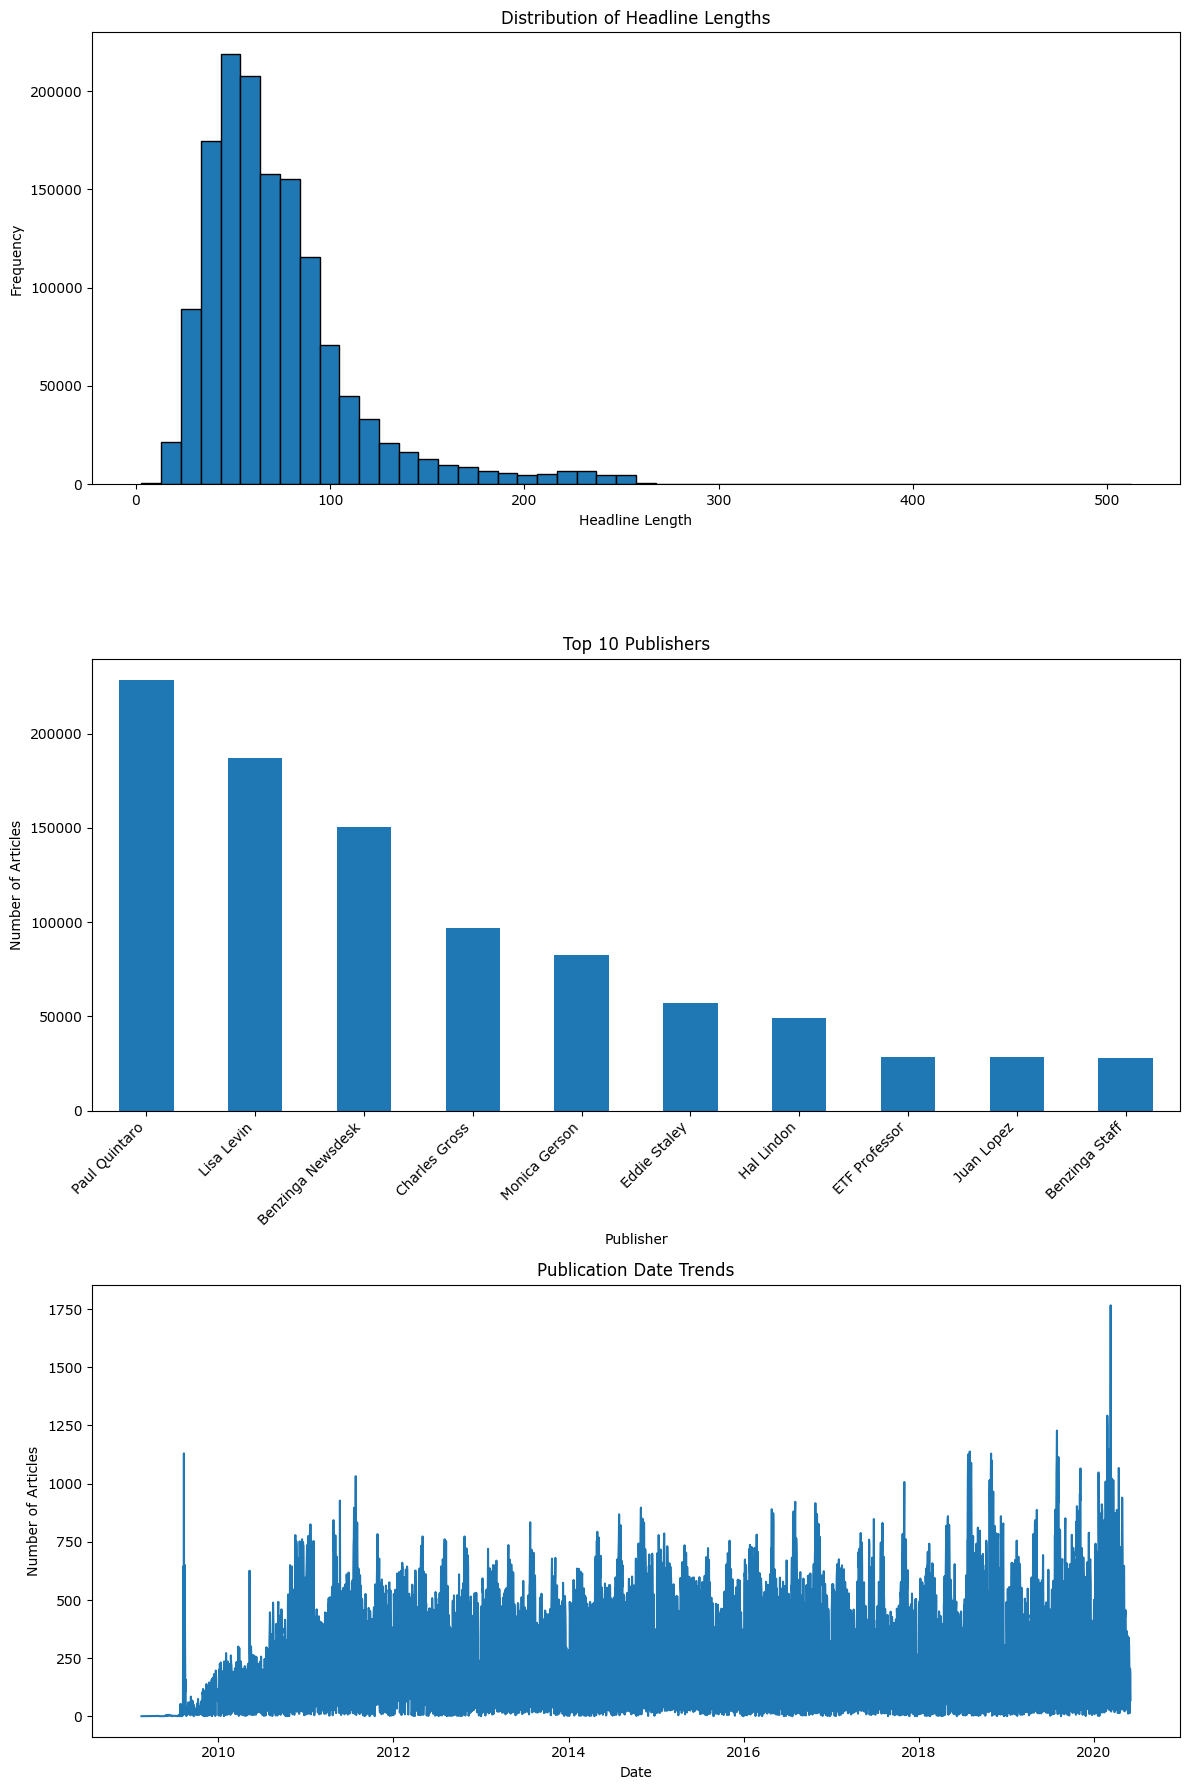

In [31]:
date_counts = data['date'].dt.date.value_counts().sort_index()

print("\nPublication Date Trends (first 10 dates):")
print(date_counts.head(10))

# Cell 6: Visualizations
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))

# Headline length distribution
ax1.hist(data['headline_length'], bins=50, edgecolor='black')
ax1.set_title('Distribution of Headline Lengths')
ax1.set_xlabel('Headline Length')
ax1.set_ylabel('Frequency')

# Top publishers
publisher_counts.head(10).plot(kind='bar', ax=ax2)
ax2.set_title('Top 10 Publishers')
ax2.set_xlabel('Publisher')
ax2.set_ylabel('Number of Articles')
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Publication date trends
date_counts.plot(ax=ax3)
ax3.set_title('Publication Date Trends')
ax3.set_xlabel('Date')
ax3.set_ylabel('Number of Articles')

plt.tight_layout()
plt.show()

## Text Analysis(Sentiment analysis & Topic Modeling

In [36]:
data.columns

Index(['Unnamed: 0', 'headline', 'url', 'publisher', 'date', 'stock',
       'headline_length'],
      dtype='object')

In [42]:
sia = SentimentIntensityAnalyzer()
data['sentiment'] = data['headline'].apply(lambda x: sia.polarity_scores(x)['compound'])
sentiment_stats = data['sentiment'].describe()

print("\nSentiment Statistics:")
print(sentiment_stats)


Sentiment Statistics:
count    1.407328e+06
mean     6.650410e-02
std      2.714077e-01
min     -9.578000e-01
25%      0.000000e+00
50%      0.000000e+00
75%      2.023000e-01
max      9.741000e-01
Name: sentiment, dtype: float64


### Topic Modelling

In [45]:
vectorizer = CountVectorizer(stop_words='english', max_features=1000) # max_feature specify the amount of words for the feature extraction
X = vectorizer.fit_transform(data['headline'])
words = vectorizer.get_feature_names_out()
word_counts = X.sum(axis=0).A1
top_words = [words[i] for i in word_counts.argsort()[-5:][::-1]]

print(f"Total words: {len(word_counts)}")
print("\nTop Words:")
print(top_words)

Total words: 1000

Top Words:
['vs', 'stocks', 'est', 'eps', 'market']


### Time Series Analysis

In [48]:
data.columns

Index(['Unnamed: 0', 'headline', 'url', 'publisher', 'date', 'stock',
       'headline_length', 'sentiment', 'hour'],
      dtype='object')


Hourly Publication Counts:
hour
0.0    1351341
Name: count, dtype: int64

Top Publisher :
publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Name: count, dtype: int64


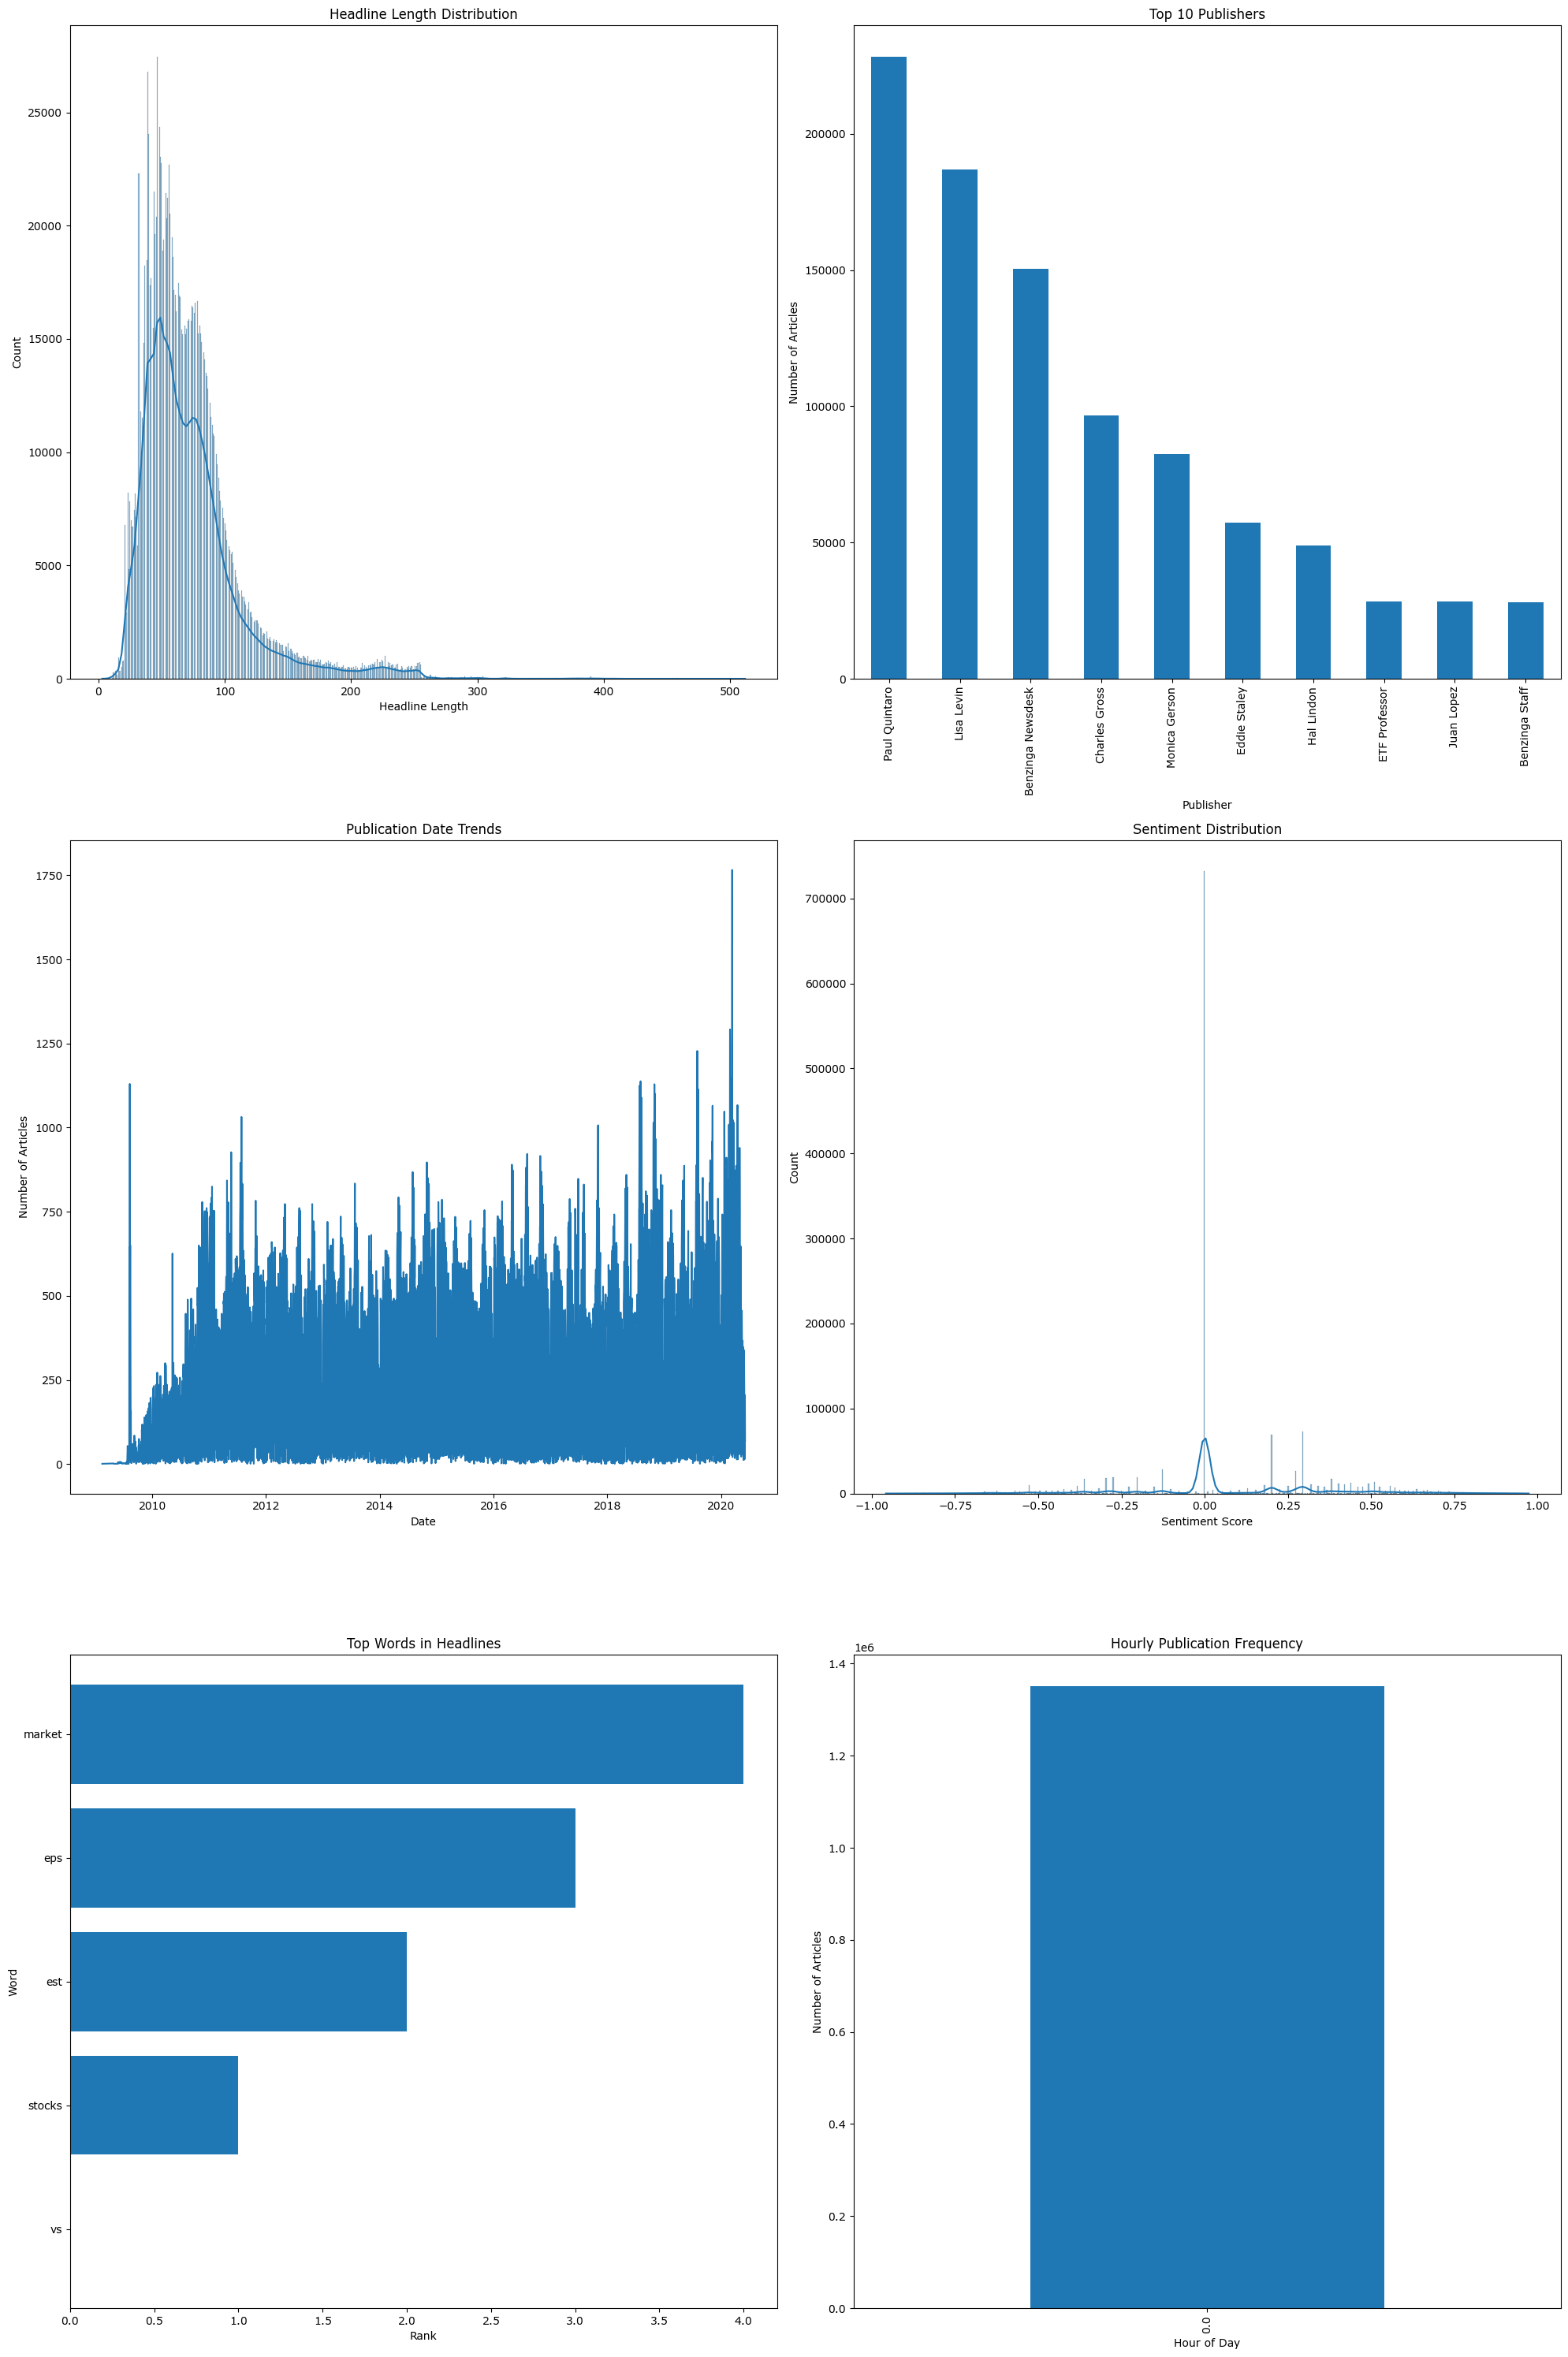

In [49]:
data['hour'] = data['date'].dt.hour
hourly_counts = data['hour'].value_counts().sort_index()

print("\nHourly Publication Counts:")
print(hourly_counts)

# Cell 7: Publisher Analysis
top_publishers = data['publisher'].value_counts().head(10)

print("\nTop Publisher :")
print(top_publishers)

# Cell 8: Visualization
fig, axes = plt.subplots(3, 2, figsize=(20, 30))

# Headline length distribution
sns.histplot(data['headline_length'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Headline Length Distribution')
axes[0, 0].set_xlabel('Headline Length')

# Top publishers
publisher_counts.head(10).plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title('Top 10 Publishers')
axes[0, 1].set_xlabel('Publisher')
axes[0, 1].set_ylabel('Number of Articles')

# Publication date trends
date_counts.plot(ax=axes[1, 0])
axes[1, 0].set_title('Publication Date Trends')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Number of Articles')

# Sentiment distribution
sns.histplot(data['sentiment'], kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Sentiment Distribution')
axes[1, 1].set_xlabel('Sentiment Score')

# Top words
axes[2, 0].barh(top_words, range(len(top_words)))
axes[2, 0].set_title('Top Words in Headlines')
axes[2, 0].set_xlabel('Rank')
axes[2, 0].set_ylabel('Word')

# Hourly publication frequency
hourly_counts.plot(kind='bar', ax=axes[2, 1])
axes[2, 1].set_title('Hourly Publication Frequency')
axes[2, 1].set_xlabel('Hour of Day')
axes[2, 1].set_ylabel('Number of Articles')

plt.tight_layout()
plt.show()